# Density Module - LocalDensity
The `freud.density` module is intended to compute a variety of quantities that relate spatial distributions of particles with other particles.
In this notebook, we demonstrate `freud`'s local density calculation, which can be used to characterize the particle distributions in some systems. 
In this example, we consider a toy example of calculating the particle density in the vicinity of a set of other points.
This can be visualized as, for example, billiard balls on a table with certain regions of the table being stickier than others.
In practice, this method could be used for analyzing, *e.g*, binary systems to determine how densely one species packs close to the surface of the other.

In [1]:
import numpy as np
import freud
import util
from helper_functions.box_plotting import box_2d_to_points
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Define some helper plotting functions.
def plot_lattice(box, points, size=1500):
    """Helper function for plotting points on a lattice."""
    fig, ax = plt.subplots(1, 1, figsize=(9, 6))
    box_points = box_2d_to_points(box)
    ax.plot(box_points[:, 0], box_points[:, 1], color='k')
    
    ax.scatter(points[:, 0], points[:, 1], s=size, marker='o',
               facecolors='None', linestyle='--',
               edgecolors=list(plt.rcParams['axes.prop_cycle'])[0]['color'])
    return fig, ax

def plot_rdf(box, points, prop, rmax = 3, drs = [0.15, 0.04, 0.001]):
    """Helper function for plotting RDFs."""
    fig, axes = plt.subplots(1, len(drs), figsize=(16, 3))
    for i, dr in enumerate(drs):
        rdf = freud.density.RDF(rmax, dr)
        rdf.compute(box, points)
        axes[i].plot(rdf.R, getattr(rdf, prop))
        axes[i].set_title("Bin width: {:.3f}".format(dr), fontsize=16)
    return fig, ax

Let us consider a set of regions on a square lattice.

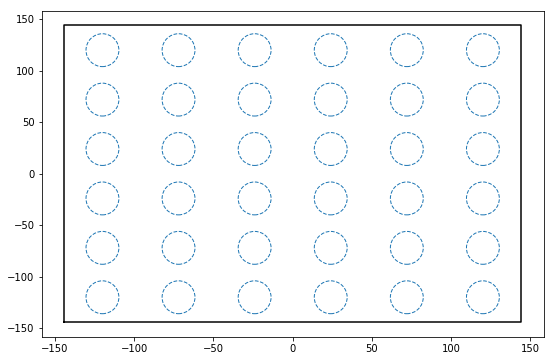

In [3]:
area = 1
ref_area = area*100
markersize = area*4/np.pi*np.sqrt(plt.rcParams['figure.dpi'])
ref_markersize = ref_area*4/np.pi*np.sqrt(plt.rcParams['figure.dpi'])
num = 6
scale = num*4
box, ref_points = util.make_square(num, num, scale=scale)
ref_points[..., [0, 1]] += scale
fig, ax = plot_lattice(box, ref_points, ref_markersize)

Now let's add a second set of points to this density, where the number of points is normally distributed with covariance proportional to the sizes above.

In [4]:
points = []
cov_basis = np.arange(1, ref_points.shape[0]+1)**2*num
for i, p in enumerate(ref_points):
    cov = cov_basis[i]*np.eye(3)
    cov[2, 2] = 0  # Nothing in z
    points.append(
        np.random.multivariate_normal(p, cov, size=(50,)))
points = box.wrap(np.concatenate(points))

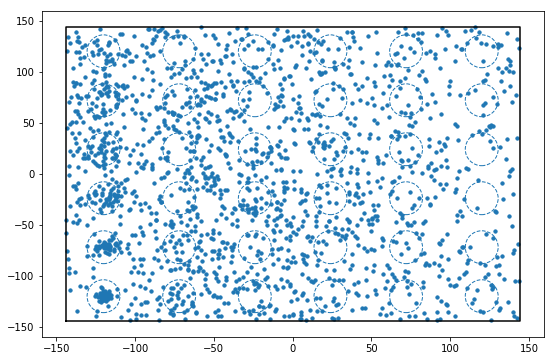

In [5]:
fig, ax = plot_lattice(box, ref_points, ref_markersize)
ax.scatter(points[:, 0], points[:, 1], markersize);

Evidently, some of these regions are no much denser than others.
In order to compute the actual densities, we can leverage the LocalDensity class.
The class allows you to specify a set of reference points around which the number of other points is computed.
These other points can, but need not be, distinct from the reference points.
In our case, we want to use the big circles as our reference points with the small circles as our data points.

When we construct the LocalDensity class, there are three arguments.
The first is the radius from the reference points within which particles should be included in the reference point's counter.
The second and third are the volume and the circumsphere diameters of the **data points**, not the reference points.
This distinction is critical for getting appropriate density values, since these values are used to actually check cutoffs and calculate the density.

*Note that the plotted sizes of points do not match the true sizes, in this toy example we simply look at the number of neighbors rather than the total density to understand the trends that we see.*

In [6]:
density = freud.density.LocalDensity(15, area, 2*np.sqrt(area/np.pi))
num_neighbors = density.compute(box, ref_points, points).num_neighbors

Text(0,0.5,'Density')

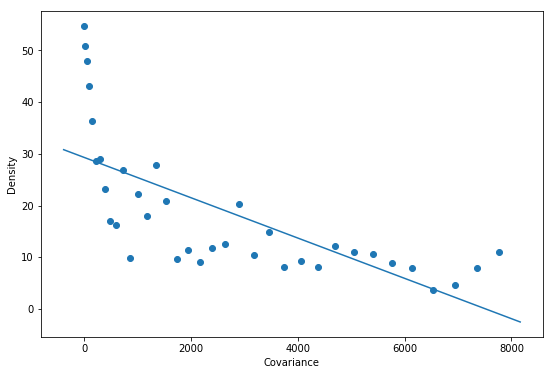

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
coeffs, residuals, _, _, _ = np.polyfit(cov_basis, num_neighbors, 1, full=True)
poly = np.poly1d(coeffs)
residual = residuals[0]

ax.scatter(cov_basis, num_neighbors)
x = np.linspace(*ax.get_xlim(), 30)
l = ax.plot(x, poly(x), label="Best fit");
ax.set_xlabel("Covariance")
ax.set_ylabel("Density");

As expected, we see that increasing the variance in the number of points centered at a particular reference point decreases the total density at that point
The trend is noisy since we are randomly sampling possible positions, but the general behavior is clear.